In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit import QuantumCircuit, transpile, assemble
from scipy.optimize import minimize

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

## Max-Cut Problem

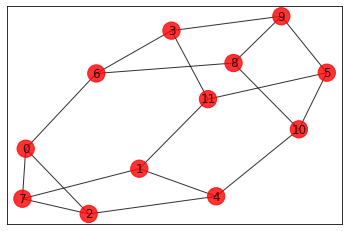

In [4]:
n = 12
G=nx.random_regular_graph(3,n)
G.add_nodes_from(np.arange(0,n,1))

# elist = [e for e in G.edges]
elist = [(4, 10), (4, 2), (4, 1), (10, 8), (10, 5), (2, 7), (2, 0), (0, 7), (0, 6), (7, 1), (5, 11), (5, 9), (11, 1), (11, 3), (6, 8), (6, 3), (8, 9), (9, 3)]

# tuple is (i,j) where (i,j) is the edge
G.remove_edges_from(G.edges)    # for specific example
G.add_edges_from(elist)
colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=300, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G,colors,pos)

QAOA ansatz

In [5]:
def QAOA_circuit(G, gammas, betas):
    E = G.edges
    V = G.nodes
    qc = QuantumCircuit(len(V),len(V))
    
    qc.h(range(len(V)))
    qc.barrier()
    for i in range(len(gammas)):
        for edge in E:
            qc.cx(edge[0],edge[1])
            qc.rz(-gammas[i],edge[1])
            qc.cx(edge[0],edge[1])

            qc.barrier()

        qc.rx(2*betas[i],range(len(V)))

        qc.barrier()
    
    qc.measure(range(len(V)),range(len(V)))
    return qc

qc = QAOA_circuit(G,[1,2],[3,4])
# qc.draw('mpl')

## p=1 case

Find an optimal parameter $\beta^*$ and $\gamma^*$.

In [6]:
def get_binary_vector(G,gammas,betas,shots=10000):
  backend = Aer.get_backend("qasm_simulator")
  qc = QAOA_circuit(G,gammas,betas)
  tqc = transpile(qc, backend)
  qobj = assemble(tqc, shots=shots)
  QAOA_results = backend.run(qobj).result()
  counts = QAOA_results.get_counts()
  max_vec = max(counts.keys(),key=(lambda k: counts[k]))
  # reverse string
  return max_vec[::-1], counts

## Cost Function

In [7]:
def cost(G,binary_vector):
    result = 0
    for edge in G.edges:
        if binary_vector[edge[0]] is not binary_vector[edge[1]]:
            result += 1
    return result

In [8]:
def theory_max(G):
    # Using Brute Force approach
    max_cost = 0
    max_vector = ""
    num = len(G.nodes)
    for i in range(pow(2,num)):
        current_cost = cost(G,"{0:b}".format(i).zfill(num))
        if current_cost > max_cost:
            max_cost = current_cost
            max_vector = "{0:b}".format(i).zfill(num)
    return max_vector[::-1], max_cost

max_vec, max_result = theory_max(G)
print(max_result)

16


$r = {{C(z)}\over{C_{max}}}$

In [9]:
def cost_exp(G,gammas,betas):
    # get an expectation value of cost function
    _, sampledxs = get_binary_vector(G,gammas,betas)
    total_cnt = 0
    sum_of_cost = 0
    for vec in sampledxs:
        sum_of_cost += sampledxs[vec] * cost(G,vec[::-1])
        total_cnt += sampledxs[vec]
    exp = sum_of_cost / total_cnt
    return exp
    
a = cost_exp(G,[1,2],[3,4])
print(a)

8.8788


In [10]:
step_size = 0.1

a_gamma = np.arange(0, 2*np.pi, step_size)
a_beta = np.arange(0, np.pi, step_size)
r_exp = np.zeros((len(a_beta),len(a_gamma)))    # cost expectation / theoretical maximum cost

gamma_op, beta_op, op_cost = (0, 0, 0)

for i, beta in enumerate(a_beta):
  for j, gamma in enumerate(a_gamma):
    r_exp[i,j] = cost_exp(G,gammas=[gamma],betas=[beta]) / max_result
    if r_exp[i,j] > op_cost:
      gamma_op, beta_op, op_cost = (gamma, beta, r_exp[i,j] / max_result)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)


6.2 3.1


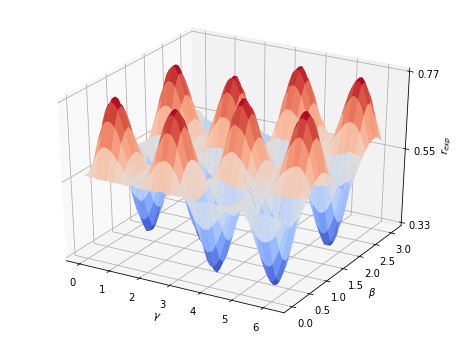

In [11]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure(figsize=(8,6))
ax  = fig.gca(projection='3d')
ax.set_xlabel('$\gamma$')
ax.set_ylabel('$β$')
ax.set_zlabel('$r_{exp}$')
surf = ax.plot_surface(a_gamma, a_beta, r_exp, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

print(gamma_op,beta_op)

## Get the cost of the most recently appeared vector

In [15]:

max_vec, cnt = get_binary_vector(G,[gamma_op],[beta_op])
ct = cost(G,max_vec)
print(ct)

10


## p > 1 case

## Using initial parameter interpolation

In [16]:
def interpolation(p,gammas,betas):
  gammas = [0] + list(gammas) + [0]
  betas = [0] + list(betas) + [0]
  new_gammas = []
  new_betas = []
  for i in range(1,p+2):
    gval = (i-1)/p * gammas[i-1] + (p-i+1)/p * gammas[i]
    bval = (i-1)/p * betas[i-1] + (p-i+1)/p * betas[i]
    new_gammas.append(gval)
    new_betas.append(bval)
  return new_gammas, new_betas

In [26]:
from scipy.optimize import minimize
def iter_p(G,p,gamma,beta):
  def f(params):
    p = int(len(params)/2)
    return -cost_exp(G,params[:p],params[p:]) / max_result

  g, b = interpolation(p-1,gamma,beta)

  initial_params = g + b
  
  initial_params = np.array(initial_params)

  opt = minimize(f,initial_params,method='COBYLA',options={'maxiter':10000000},tol=1e-10)
  print("cost p = ",p,": ",-opt.fun)
  return opt.x[:p], opt.x[p:]


In [27]:
r_exp_list = []
max_list = []

r_exp_list.append(cost_exp(G,[gamma_op],[beta_op]) / max_result)
max_vec, cnt = get_binary_vector(G,[gamma_op],[beta_op])
ct = cost(G,max_vec)
max_list.append(ct/max_result)

In [28]:
gammas = [gamma_op]
betas = [beta_op]
for p in range(2,21):
  gammas, betas = iter_p(G,p,gammas,betas)
  r_exp_list.append(cost_exp(G,gammas,betas) / max_result)
  max_vec, cnt = get_binary_vector(G,gammas,betas)
  ct = cost(G,max_vec)
  max_list.append(ct/max_result)
  print(r_exp_list[p-1],max_list[p-1])
  # print(gamma,beta)

cost p =  2 :  0.8561875
0.85865 1.0
cost p =  3 :  0.79570625
0.7925125 1.0
cost p =  4 :  0.88758125
0.88761875 1.0
cost p =  5 :  0.889475
0.889475 1.0
cost p =  6 :  0.86906875
0.87079375 1.0
cost p =  7 :  0.866525
0.86821875 1.0
cost p =  8 :  0.84876875
0.8486625 1.0
cost p =  9 :  0.91358125
0.91275 1.0
cost p =  10 :  0.88139375
0.88465625 1.0
cost p =  11 :  0.90305
0.902175 1.0
cost p =  12 :  0.92804375
0.925475 1.0
cost p =  13 :  0.97145
0.97028125 1.0
cost p =  14 :  0.91943125
0.91865 1.0
cost p =  15 :  0.92411875
0.92265 1.0
cost p =  16 :  0.96264375
0.96195625 1.0
cost p =  17 :  0.95385
0.953575 1.0
cost p =  18 :  0.9168375
0.9161125 1.0
cost p =  19 :  0.9588625
0.960875 1.0
cost p =  20 :  0.949575
0.95063125 1.0


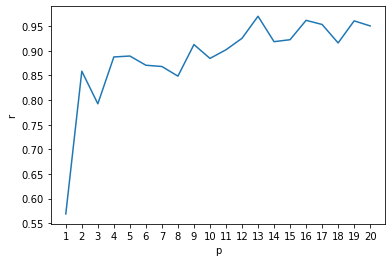

In [29]:
plt.xticks(np.arange(0,21,1))
plt.xlabel('p')
plt.ylabel('r')
plt.plot(np.linspace(1,20,20),r_exp_list)

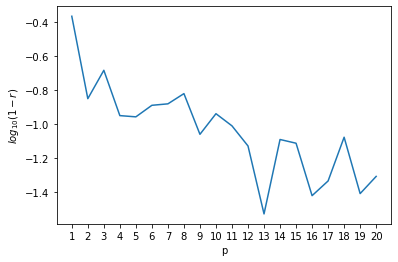

In [30]:
plt.xticks(np.arange(0,21,1))
plt.xlabel('p')
plt.ylabel('$log_{10}(1-r)$')
plt.plot(np.linspace(1,20,20),np.log10(1-np.array(r_exp_list)).tolist())

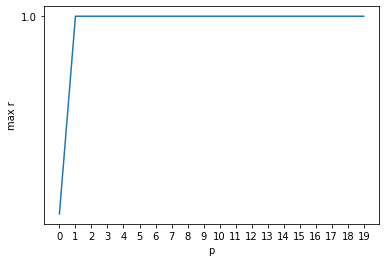

In [31]:
plt.xticks(np.arange(0,21,1))
plt.yticks(np.arange(0,1.5,0.5))
plt.xlabel('p')
plt.ylabel('max r')
plt.plot(max_list)